cell 1 :Import Libraries

In [ ]:
 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve)
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
import warnings 
warnings.filterwarnings('ignore')
from imblearn.over_sampling import SMOTE


cell 2 : Load Data

In [ ]:

df = pd.read_csv("C:/Users/Anandu/Desktop/tcs/tele_data.csv")
print(df.head())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [41]:
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
df.info()
print("\nMissing Values:")
print(df.isnull().sum())
print("\nDescriptive Statistics (Numerical):")
print(df.describe())

Dataset Shape: (7032, 24)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              7032 non-null   object 
 1   SeniorCitizen       7032 non-null   int64  
 2   Partner             7032 non-null   object 
 3   Dependents          7032 non-null   object 
 4   tenure              7032 non-null   int64  
 5   PhoneService        7032 non-null   object 
 6   MultipleLines       7032 non-null   object 
 7   InternetService     7032 non-null   object 
 8   OnlineSecurity      7032 non-null   object 
 9   OnlineBackup        7032 non-null   object 
 10  DeviceProtection    7032 non-null   object 
 11  TechSupport         7032 non-null   object 
 12  StreamingTV         7032 non-null   object 
 13  StreamingMovies     7032 non-null   object 
 14  Contract            7032 non-null   object 
 15  PaperlessBilli

cell 5 : EDA

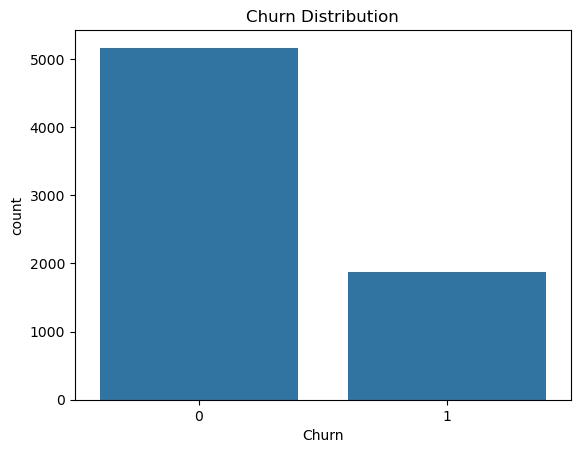

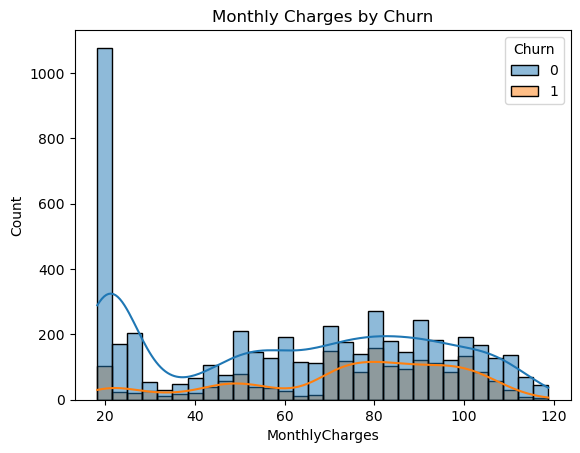

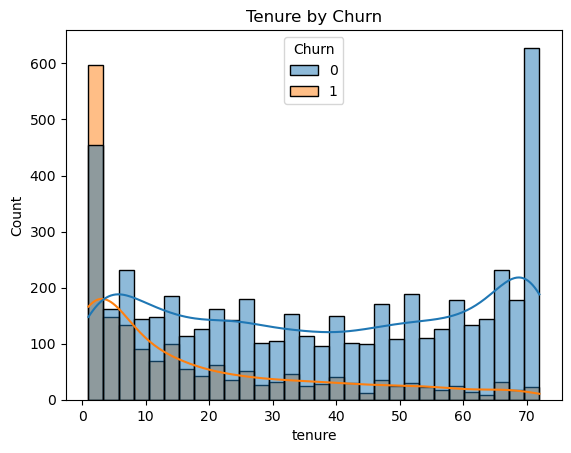

In [ ]:

# Churn distribution
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.show()

# Monthly Charges distribution by Churn
sns.histplot(data=df, x='MonthlyCharges', hue='Churn', kde=True, bins=30)
plt.title('Monthly Charges by Churn')
plt.show()

# Tenure distribution by Churn
sns.histplot(data=df, x='tenure', hue='Churn', kde=True, bins=30)
plt.title('Tenure by Churn')
plt.show()

CATERGORICAL FEATURES VS CHURN

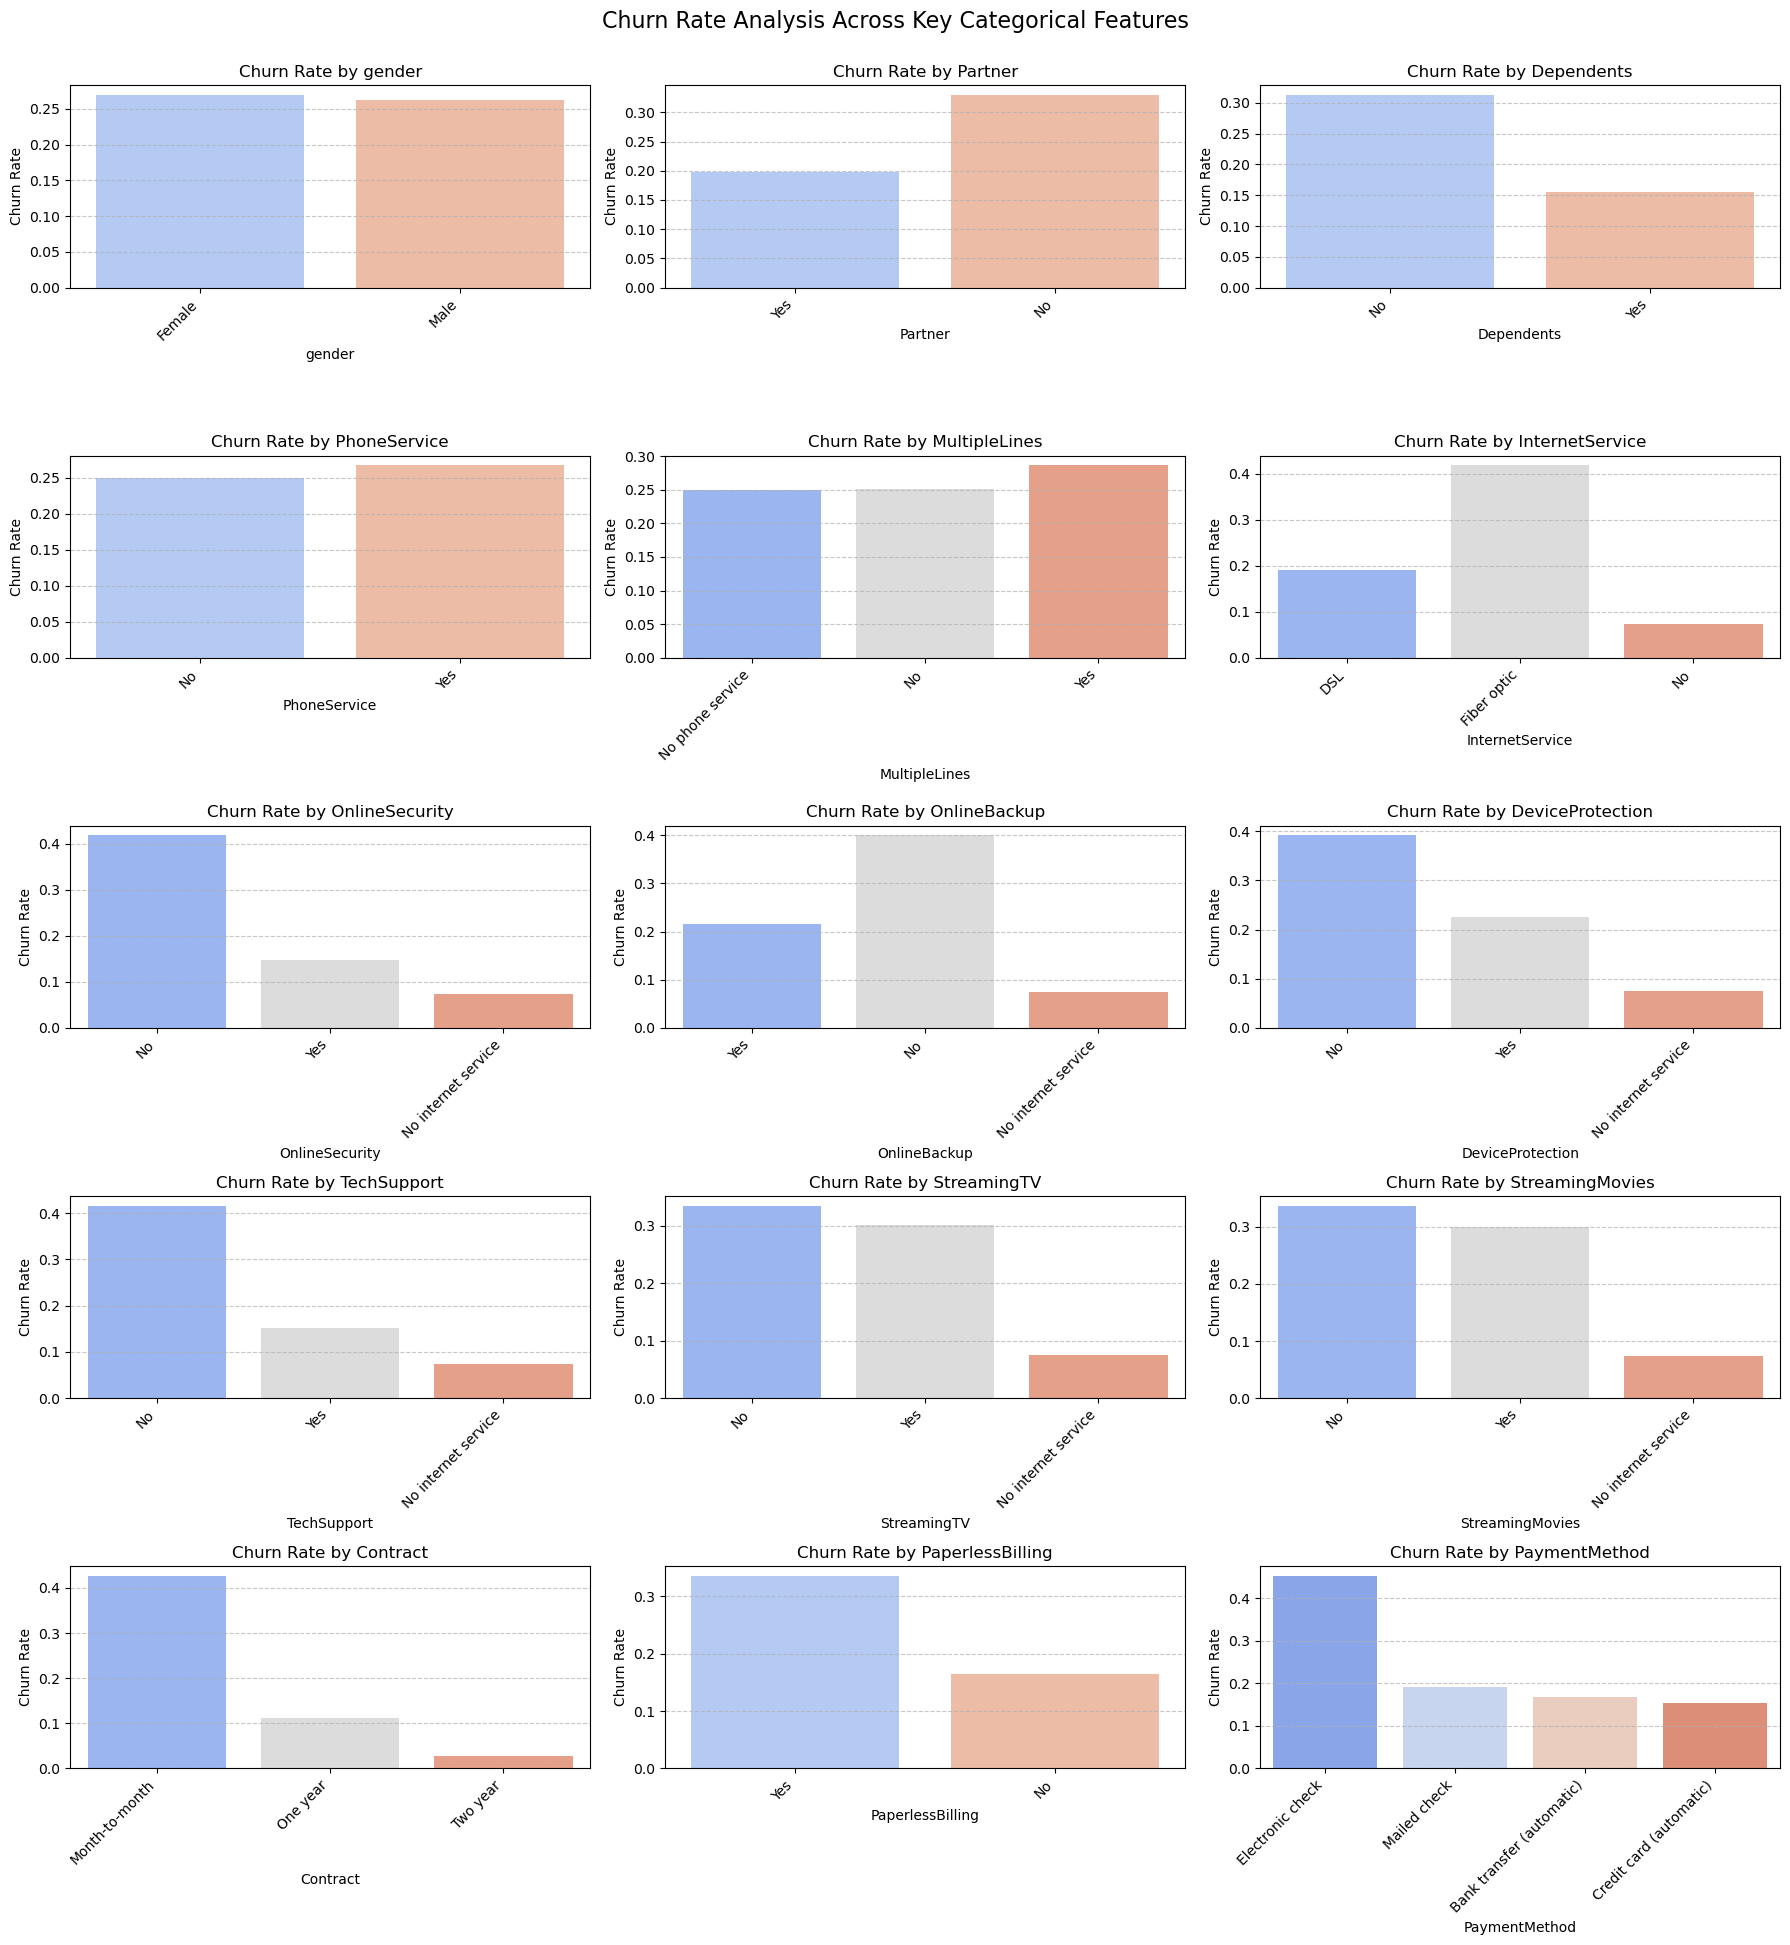

In [ ]:


# Select some key categorical features from your original df
categorical_features_for_plot = [
    'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
    'PaperlessBilling', 'PaymentMethod'
]

plt.figure(figsize=(18, 20)) 

for i, feature in enumerate(categorical_features_for_plot):
    if feature in df.columns:
        plt.subplot(5, 3, i + 1) 
        sns.barplot(
            data=df,
            x=feature,
            y=y, 
            errorbar=None, 
            palette='coolwarm'
        )
        plt.title(f'Churn Rate by {feature}', fontsize=12)
        plt.xlabel(feature, fontsize=10)
        plt.ylabel('Churn Rate', fontsize=10)
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
    else:
        print(f"Warning: Feature '{feature}' not found in DataFrame 'df'. Skipping plot.")

plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout
plt.suptitle('Churn Rate Analysis Across Key Categorical Features', fontsize=16, y=1.0)
plt.show()

NUMERICAL FEATURES VS CHURN

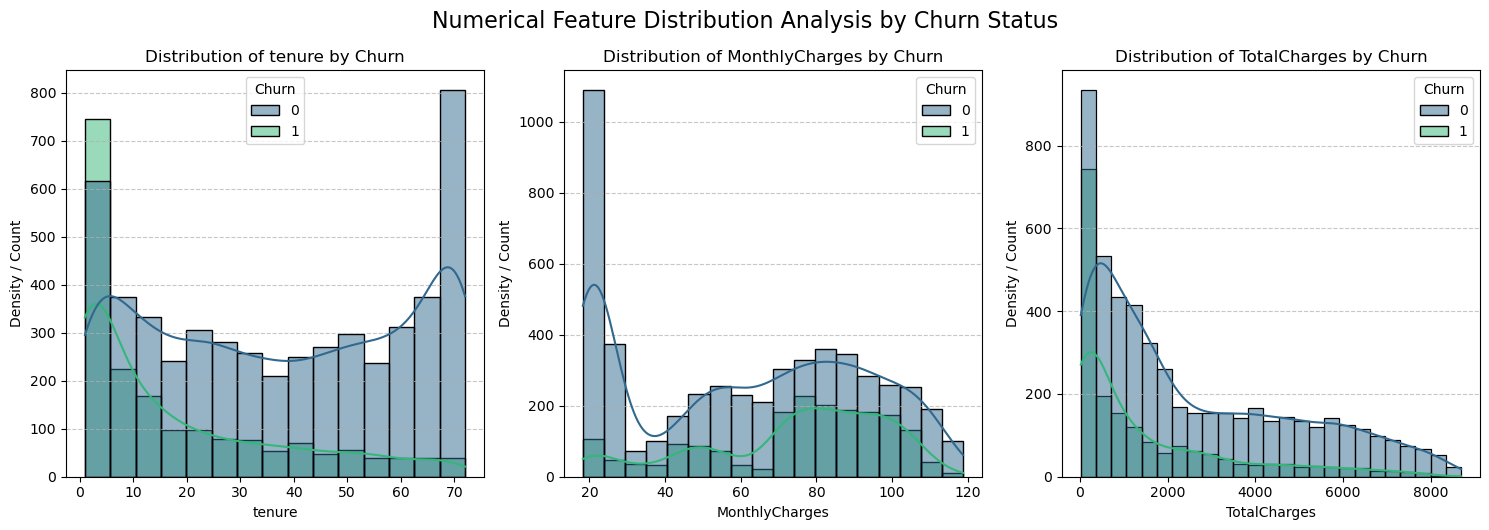

In [ ]:


numerical_features_for_plot = ['tenure', 'MonthlyCharges', 'TotalCharges']

plt.figure(figsize=(15, 5)) # Adjust figure size as needed

for i, feature in enumerate(numerical_features_for_plot):
    if feature in df.columns:
        plt.subplot(1, 3, i + 1) 
        sns.histplot(
            data=df,
            x=feature,
            hue=y, 
            kde=True, 
            palette='viridis',
            common_norm=False 
        )
        plt.title(f'Distribution of {feature} by Churn', fontsize=12)
        plt.xlabel(feature, fontsize=10)
        plt.ylabel('Density / Count', fontsize=10)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
    else:
        print(f"Warning: Feature '{feature}' not found in DataFrame 'df'. Skipping plot.")

plt.tight_layout()
plt.suptitle('Numerical Feature Distribution Analysis by Churn Status', fontsize=16, y=1.05) 
plt.show()

DATA CLEANING AND FEATURE ENGINEERING

In [ ]:

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna(subset=['TotalCharges'])
df.reset_index(drop=True, inplace=True)

# Create AvgChargesPerMonth feature
df['AvgChargesPerMonth'] = df['TotalCharges'] / df['tenure']
df['AvgChargesPerMonth'].replace([np.inf, -np.inf], 0, inplace=True)
df['AvgChargesPerMonth'].fillna(0, inplace=True)

# Drop customerID if it exists
if 'customerID' in df.columns:
    df.drop('customerID', axis=1, inplace=True)
else:
    print("Warning: 'customerID' column not found, skipping drop operation.")

# Feature Engineering (Examples - add more if relevant)
# Total number of services
df['TotalServices'] = (df[['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
                           'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']] == 'Yes').sum(axis=1)

# Binary flags for internet/phone service presence
df['HasInternet'] = df['InternetService'].apply(lambda x: 1 if x != 'No' else 0)
df['HasPhone'] = df['PhoneService'].apply(lambda x: 1 if x != 'No phone service' else 0)

# Encode target variable 'Churn'
le_churn = LabelEncoder()
df['Churn'] = le_churn.fit_transform(df['Churn']) # 'No' -> 0, 'Yes' -> 1
y = df['Churn'] # Define your target variable
X = df.drop('Churn', axis=1) # Define your features by dropping the target

Data Splitting, Categorical Encoding, and Scaling

In [ ]:
 # Separate features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Identify categorical and numerical columns
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()

# Apply Label Encoding to categorical features for TabNet
# TabNet expects categorical features to be integer encoded for its embeddings.
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


scaler = StandardScaler()


X_train_resampled_scaled = X_train_resampled.copy()
X_test_scaled = X_test.copy()


X_train_resampled_scaled[numerical_cols] = scaler.fit_transform(X_train_resampled[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols]) #

X_train_np = X_train_resampled_scaled.values
y_train_np = y_train_resampled.values
X_test_np = X_test_scaled.values
y_test_np = y_test.values

# Define categorical feature indices and dimensions for TabNet
# These indices are based on the column order in the final X_train_resampled_scaled DataFrame
cat_idxs = [X_train_resampled_scaled.columns.get_loc(col) for col in cat_cols]
cat_dims = [X_train_resampled_scaled[col].nunique() for col in cat_cols]

MODEL BUILDING AND TRAINING

In [ ]:

tabnet_model = TabNetClassifier(
    verbose=1,
    seed=42,
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=2,           
    n_d=24,                 
    n_a=24,                 
    n_steps=5,               
    gamma=1.5,
    lambda_sparse=1e-4,      
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    scheduler_params={"step_size":50, "gamma":0.9},
    mask_type='entmax'
)

tabnet_model.fit(
    X_train_np, y_train_np,
    eval_set=[(X_test_np, y_test_np)],
    eval_metric=['accuracy', 'auc'],
    max_epochs=250,
    patience=40,
    batch_size=1024,
    virtual_batch_size=128
)

epoch 0  | loss: 0.99244 | val_0_accuracy: 0.62331 | val_0_auc: 0.72519 |  0:00:01s
epoch 1  | loss: 0.57347 | val_0_accuracy: 0.66596 | val_0_auc: 0.73233 |  0:00:02s
epoch 2  | loss: 0.49492 | val_0_accuracy: 0.742   | val_0_auc: 0.7821  |  0:00:03s
epoch 3  | loss: 0.46553 | val_0_accuracy: 0.73774 | val_0_auc: 0.78075 |  0:00:04s
epoch 4  | loss: 0.44189 | val_0_accuracy: 0.73276 | val_0_auc: 0.77127 |  0:00:04s
epoch 5  | loss: 0.42922 | val_0_accuracy: 0.75124 | val_0_auc: 0.78716 |  0:00:05s
epoch 6  | loss: 0.41301 | val_0_accuracy: 0.71997 | val_0_auc: 0.77866 |  0:00:06s
epoch 7  | loss: 0.40283 | val_0_accuracy: 0.76972 | val_0_auc: 0.78881 |  0:00:08s
epoch 8  | loss: 0.39814 | val_0_accuracy: 0.76333 | val_0_auc: 0.79602 |  0:00:11s
epoch 9  | loss: 0.39014 | val_0_accuracy: 0.76759 | val_0_auc: 0.79608 |  0:00:13s
epoch 10 | loss: 0.38468 | val_0_accuracy: 0.77328 | val_0_auc: 0.80401 |  0:00:15s
epoch 11 | loss: 0.37908 | val_0_accuracy: 0.78252 | val_0_auc: 0.80475 |  0

--- Metrics with Chosen Threshold: 0.4201 ---
Accuracy: 0.749822316986496
Precision: 0.522
Recall: 0.6978609625668449
F1 Score: 0.597254004576659
ROC AUC: 0.8255056400805504

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.77      0.82      1033
           1       0.52      0.70      0.60       374

    accuracy                           0.75      1407
   macro avg       0.70      0.73      0.71      1407
weighted avg       0.78      0.75      0.76      1407



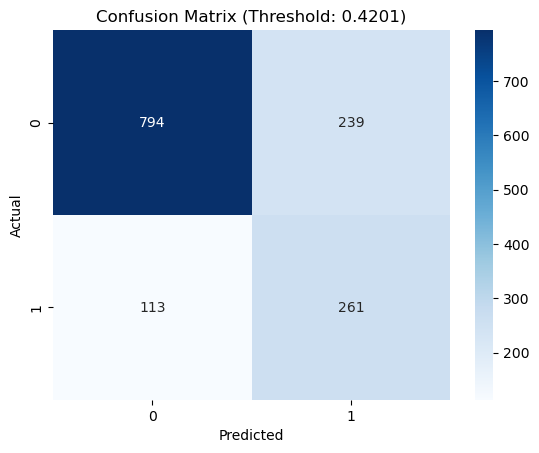

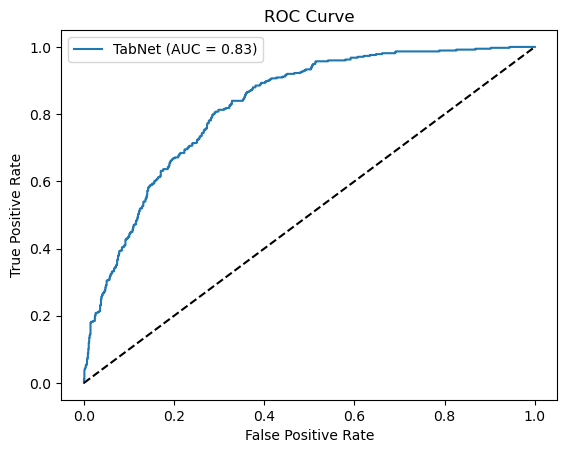

In [ ]:
# Model Evaluation with Chosen Threshold (Final Version)

y_proba = tabnet_model.predict_proba(X_test_np)[:, 1]


chosen_threshold = 0.4201 #  chosen threshold for 70% Recall


y_pred = (y_proba >= chosen_threshold).astype(int)

print(f"--- Metrics with Chosen Threshold: {chosen_threshold:.4f} ---")
print("Accuracy:", accuracy_score(y_test_np, y_pred))
print("Precision:", precision_score(y_test_np, y_pred))
print("Recall:", recall_score(y_test_np, y_pred))
print("F1 Score:", f1_score(y_test_np, y_pred))
print("ROC AUC:", roc_auc_score(y_test_np, y_proba)) 
print("\nClassification Report:\n", classification_report(y_test_np, y_pred))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test_np, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix (Threshold: {chosen_threshold:.4f})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


fpr, tpr, _ = roc_curve(y_test_np, y_proba)
plt.plot(fpr, tpr, label='TabNet (AUC = {:.2f})'.format(roc_auc_score(y_test_np, y_proba)))
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

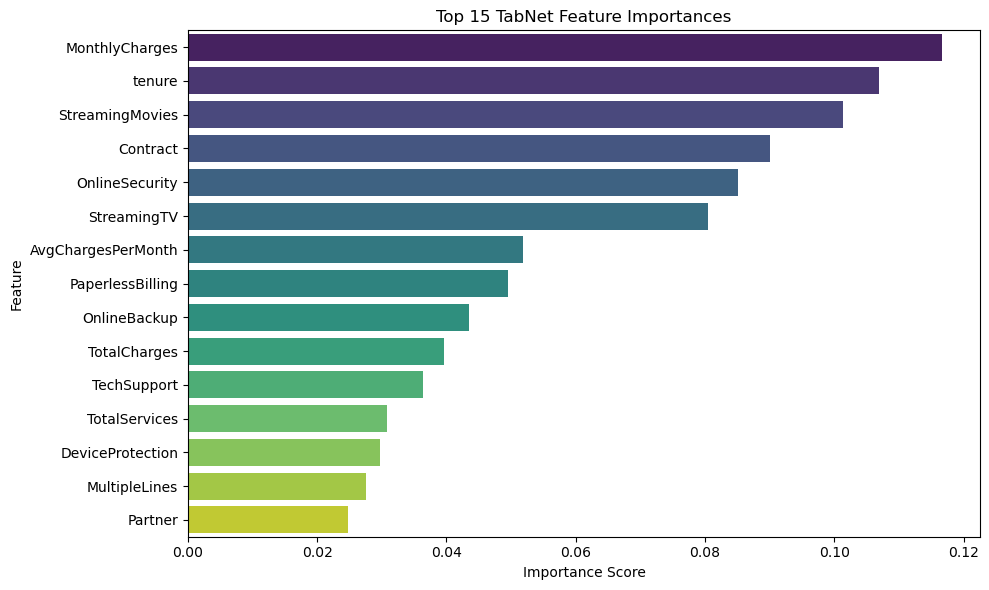

In [35]:
# Cell 8: Feature Importance Analysis
importances = tabnet_model.feature_importances_
features = X.columns
fi_df = pd.DataFrame({'feature': features, 'importance': importances})
fi_df = fi_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=fi_df.head(15), palette="viridis")
plt.title("Top 15 TabNet Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Threshold for Recall closest to 70.0%: 0.4201

--- Metrics with Threshold: 0.4201 (Target Recall ~70.0%) ---
Accuracy: 0.7505330490405118
Precision: 0.5229540918163673
Recall: 0.7005347593582888
F1 Score: 0.5988571428571429

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.77      0.82      1033
           1       0.52      0.70      0.60       374

    accuracy                           0.75      1407
   macro avg       0.70      0.73      0.71      1407
weighted avg       0.78      0.75      0.76      1407



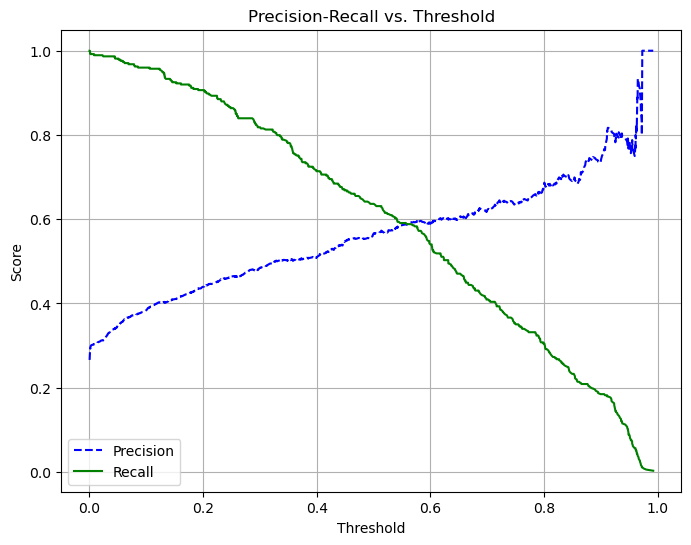

In [36]:
# Cell 9: Threshold Optimization and Re-evaluation

# Get predicted probabilities for the positive class (Churn)
y_proba = tabnet_model.predict_proba(X_test_np)[:, 1]

# --- Option 1: Find a threshold for a desired Recall (e.g., 70% Recall) ---
# You can iterate through thresholds or use precision_recall_curve
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test_np, y_proba)

# Find threshold where recall is closest to a target (e.g., 0.70)
target_recall = 0.70 # You can change this target recall based on business need
optimal_threshold_idx = np.argmin(np.abs(recalls - target_recall))
optimal_threshold_recall = thresholds[optimal_threshold_idx]
print(f"Threshold for Recall closest to {target_recall*100}%: {optimal_threshold_recall:.4f}")

# Re-evaluate with the new threshold
y_pred_optimal_recall = (y_proba >= optimal_threshold_recall).astype(int)

print(f"\n--- Metrics with Threshold: {optimal_threshold_recall:.4f} (Target Recall ~{target_recall*100}%) ---")
print("Accuracy:", accuracy_score(y_test_np, y_pred_optimal_recall))
print("Precision:", precision_score(y_test_np, y_pred_optimal_recall))
print("Recall:", recall_score(y_test_np, y_pred_optimal_recall))
print("F1 Score:", f1_score(y_test_np, y_pred_optimal_recall))
print("\nClassification Report:\n", classification_report(y_test_np, y_pred_optimal_recall))

# --- Option 2: Plot Precision-Recall Curve (Visual approach) ---
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

